[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Automated Dataset Generation with Grounding DINO + Segment Anything Model (SAM)

---

In this tutorial, you will learn how to automatically annotate your images using two groundbreaking models - [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) and [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything). You can then use this dataset to train a real-time object detection or instance segmentation model. Annotation of images using polygons in the traditional way is extremely time-consuming and expensive. With Grounding DINO and SAM, initial annotation takes only a few minutes and your work is reduced to manual verification of obtained labels.

![auto-annotation-with-grounded-sam](https://media.roboflow.com/notebooks/examples/auto-annotation-with-grounded-sam.png)

*Figure showing the effects of automatic annotation. The raw image on the left; Object detection annotations obtained with Grounding DINO in the middle; Instance segmentation annotations obtained with Grounding DINO + SAM on the right.*

## Complementary Materials

---

Want to learn more? 🤓 We have prepared separate tutorials where you can learn how to use Grounding DINO and Segment Anything Model (SAM). You will find all the necessary links below.

- Segment Anything Model

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643) [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

- Grounding DINO

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO) [![arXiv](https://img.shields.io/badge/arXiv-2303.05499-b31b1b.svg)](https://arxiv.org/abs/2303.05499) [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/cMa77r3YrDk) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install Grounding DINO and Segment Anything Model
- Load models
- Download Example Data
- Single Image Mask Auto Annotation
- Full Dataset Mask Auto Annotation
- Convert Object Detection to Instance Segmentation Dataset

## Let's begin! 🔥

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Nov 11 23:34:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:01:00.0 Off |                  Off |
| 42%   64C    P2             105W / 300W |  45019MiB / 49140MiB |     42%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant. 

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /


## Install Grounding DINO and Segment Anything Model

Our project will use two groundbreaking designs - [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) - for zero-shot detection and [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) - for converting boxes into segmentations. We have to install them first.


In [9]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 463 (delta 176), reused 137 (delta 137), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 21.61 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/GroundingDINO

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [10]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-rsorb4_o
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-rsorb4_o


  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=4f3fbe3c037c34caf716af3f05b9c1a9dd6be828b75e975ae4a3aa6bc8ca8ca9
  Stored in directory: /tmp/pip-ephem-wheel-cache-8tr3t9a7/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


**NOTE:** To glue all the elements of our demo together we will use the [`supervision`](https://github.com/roboflow/supervision) pip package, which will help us **process, filter and visualize our detections as well as to save our dataset**. A lower version of the `supervision` was installed with Grounding DINO. However, in this demo we need the functionality introduced in the latest versions. Therefore, we uninstall the current `supervsion` version and install version `0.6.0`.



In [11]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
0.6.0


**NOTE:** At the end of the tutorial we will upload our annotations to [Roboflow](roboflow.com). To automate this process with the API, let's install the `roboflow` pip package.

In [12]:
!pip install -q roboflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Download Grounding DINO Model Weights

To run Grounding DINO we need two files - configuration and model weights. The configuration file is part of the [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) repository, which we have already cloned. The weights file, on the other hand, we need to download. We write the paths to both files to the `GROUNDING_DINO_CONFIG_PATH` and `GROUNDING_DINO_CHECKPOINT_PATH` variables and verify if the paths are correct and the files exist on disk.

In [13]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [14]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/weights


In [15]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/weights/groundingdino_swint_ogc.pth ; exist: True


### Download Segment Anything Model (SAM) Weights

As with Grounding DINO, in order to run SAM we need a weights file, which we must first download. We write the path to local weight file to `SAM_CHECKPOINT_PATH` variable and verify if the path is correct and the file exist on disk.

In [16]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/
/weights


In [17]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/weights/sam_vit_h_4b8939.pth ; exist: True


## Load models

In [18]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

### Load Segment Anything Model (SAM)

In [20]:
SAM_ENCODER_VERSION = "vit_h"

In [21]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

## Download Example Data

Let's download few example images. Feel free to replace my images with yours. All you have to do is upload them to the `{HOME}/data` directory. If you're looking for data, take a peek at [Roboflow Universe](https://universe.roboflow.com/)! You're sure to find something interesting.

In [22]:
f"{HOME}/data"

'//data'

In [ ]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-5.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-6.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-7.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-8.jpeg

## Single Image Mask Auto Annotation

Before we automatically annotate the entire dataset let's focus for a moment on a single image.

In [19]:
SOURCE_IMAGE_PATH = f"{HOME}/data/dog-3.jpeg"
CLASSES = ['car', 'dog', 'person', 'nose', 'chair', 'shoe', 'ear']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

### Zero-Shot Object Detection with Grounding DINO

**NOTE:** To get better Grounding DINO detection we will leverage a bit of prompt engineering using `enhance_class_name` function defined below. 👇 You can learn more from our [Grounding DINO tutorial](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection/).

In [20]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [ ]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

In [ ]:
import cv2
import supervision as sv

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

### Prompting SAM with detected boxes

In [34]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [ ]:
import cv2

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

In [ ]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))

titles = [
    CLASSES[class_id]
    for class_id
    in detections.class_id
]

sv.plot_images_grid(
    images=detections.mask,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16)
)

## Full Dataset Mask Auto Annotation

In [ ]:
import os

# IMAGES_DIRECTORY = os.path.join(HOME, 'data')
IMAGES_DIRECTORY = os.path.join(HOME, 'drive', 'MyDrive', 'Pallets')
IMAGES_EXTENSIONS = ['jpg', 'jpeg', 'png']

# CLASSES = ['car', 'dog', 'person', 'nose', 'chair', 'shoe', 'ear', 'coffee', 'backpack', 'cap']
CLASSES = ['ground', 'pallet']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

### Extract labels from images

In [ ]:
import cv2
from tqdm.notebook import tqdm

images = {}
annotations = {}

image_paths = sv.list_files_with_extensions(
    directory=IMAGES_DIRECTORY, 
    extensions=IMAGES_EXTENSIONS)

for image_path in tqdm(image_paths):
    image_name = image_path.name
    image_path = str(image_path)
    image = cv2.imread(image_path)

    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    detections = detections[detections.class_id != None]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )
    images[image_name] = image
    annotations[image_name] = detections

**NOTE:** Before we save our `Detections` in Pascal VOC XML format, let's take a peek at the annotations we obtained. This step is optional, feel free to skip it.

In [ ]:
plot_images = []
plot_titles = []

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

for image_name, detections in annotations.items():
    image = images[image_name]
    plot_images.append(image)
    plot_titles.append(image_name)

    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}" 
        for _, _, confidence, class_id, _ 
        in detections]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    plot_images.append(annotated_image)
    title = " ".join(set([
        CLASSES[class_id]
        for class_id
        in detections.class_id
    ]))
    plot_titles.append(title)

sv.plot_images_grid(
    images=plot_images,
    titles=plot_titles,
    grid_size=(len(annotations), 2),
    size=(2 * 4, len(annotations) * 4)
)

### Save labels in Pascal VOC XML

Before uploading our annotations to Roboflow, we must first save them to our hard drive. To do this, we will use one of the latest `supervision` features (available with the `0.6.0` update 🔥) - [dataset save](https://roboflow.github.io/supervision/dataset/core/).

In [ ]:
# This is working on my google colab
ANNOTATIONS_DIRECTORY = os.path.join(HOME, 'drive', 'MyDrive', 'Pallet_wo_annotated')
MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.75

In [ ]:
sv.Dataset(
    classes=CLASSES,
    images=images,
    annotations=annotations
).as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)

### Upload annotations to Roboflow

Now we are ready to upload our annotations to Roboflow using the API.

In [ ]:
PROJECT_NAME = "Pallets-detection"
PROJECT_DESCRIPTION = "Pallets-detection"

In [ ]:
import roboflow
from roboflow import Roboflow

roboflow.login()

workspace = Roboflow().workspace()
new_project = workspace.create_project(
    project_name=PROJECT_NAME,
    project_license="MIT",
    project_type="instance-segmentation", 
    annotation=PROJECT_DESCRIPTION)

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os

for image_path in tqdm(image_paths):
    image_name = image_path.name
    annotation_name = f"{image_path.stem}.xml"
    image_path = str(image_path)
    annotation_path = os.path.join(ANNOTATIONS_DIRECTORY, annotation_name)
    new_project.upload(
        image_path=image_path, 
        annotation_path=annotation_path, 
        split="train", 
        is_prediction=True, 
        overwrite=True, 
        tag_names=["auto-annotated-with-grounded-sam"],
        batch_name="auto-annotated-with-grounded-sam"
    )

## Convert Object Detection to Instance Segmentation Dataset

If you already have your dataset but it is annotated with bounding boxes, you can quickly and easily convert it to instance segmentation one. SAM allows using boxes as prompts. You can learn more about it from [this](https://blog.roboflow.com/how-to-use-segment-anything-model-sam/) tutorial.

### Download Object Detection Dataset from Roboflow

To use the dataset in this tutorial make sure to download it in [Pascal VOC XML](https://roboflow.com/formats/pascal-voc-xml) format. We will use [BlueBerries dataset](https://universe.roboflow.com/inkyu-sa-e0c78/blueberries-u0e84) as example.

In [ ]:
%cd {HOME}
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="EUZp2b27rzpV8LxW7HGi")
project = rf.workspace("wrenchdetectionlabel").project("pallets-detection-cotil")
version = project.version(1)
dataset = version.download("voc")

In [25]:
dataset.location

'/Pallets-detection-1'

In [26]:
!ls {dataset.location}

README.dataset.txt  README.roboflow.txt  test  train  valid


### Load and Visualize Object Detection Dataset with Supervision

Learn more about Supervision Dataset support from our [documentation](https://roboflow.github.io/supervision/dataset/core/).

In [27]:
object_detection_dataset = sv.Dataset.from_pascal_voc(
    images_directory_path=f"{dataset.location}/train",
    annotations_directory_path=f"{dataset.location}/train"
)

In [28]:
import random
random.seed(9001)

**NOTE:** Rerun the cell below 👇 to take a look at different image from the dataset.

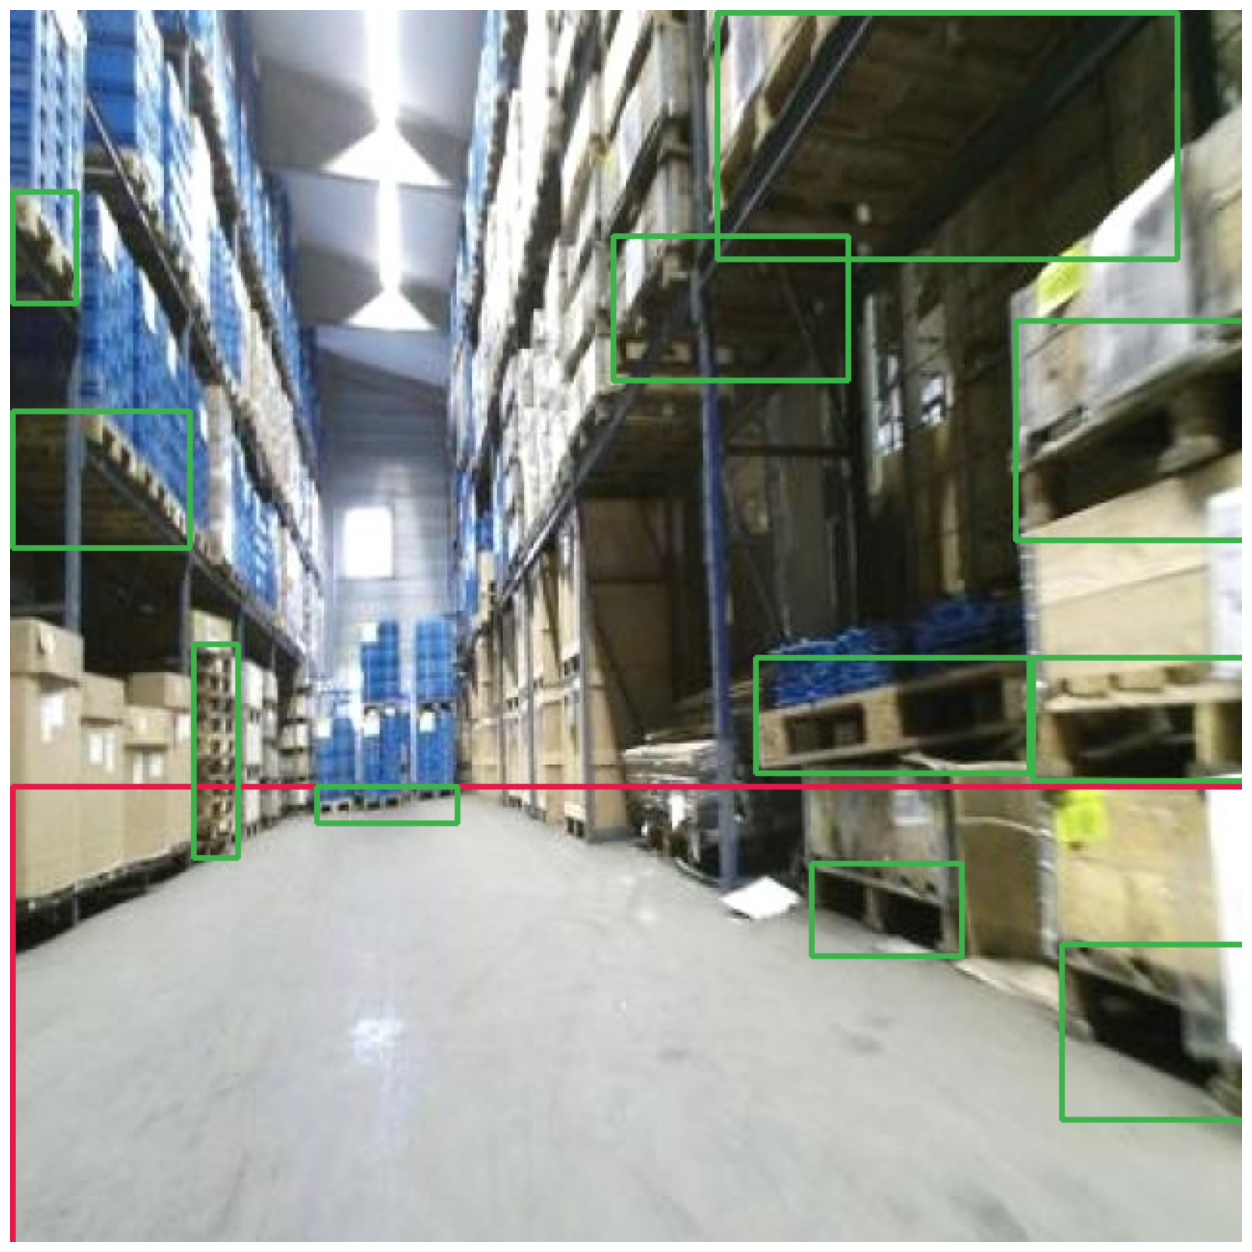

In [29]:
image_names = list(object_detection_dataset.images.keys())
image_name = random.choice(image_names)

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]

box_annotator = sv.BoxAnnotator()

annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

### Run SAM convert Boxes into Masks

In [ ]:
from tqdm import tqdm
import cv2

for image_name, image in tqdm(object_detection_dataset.images.items()):
    detections = object_detection_dataset.annotations[image_name]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

**NOTE:** Rerun the cell below 👇 to take a look at different image from converted dataset.

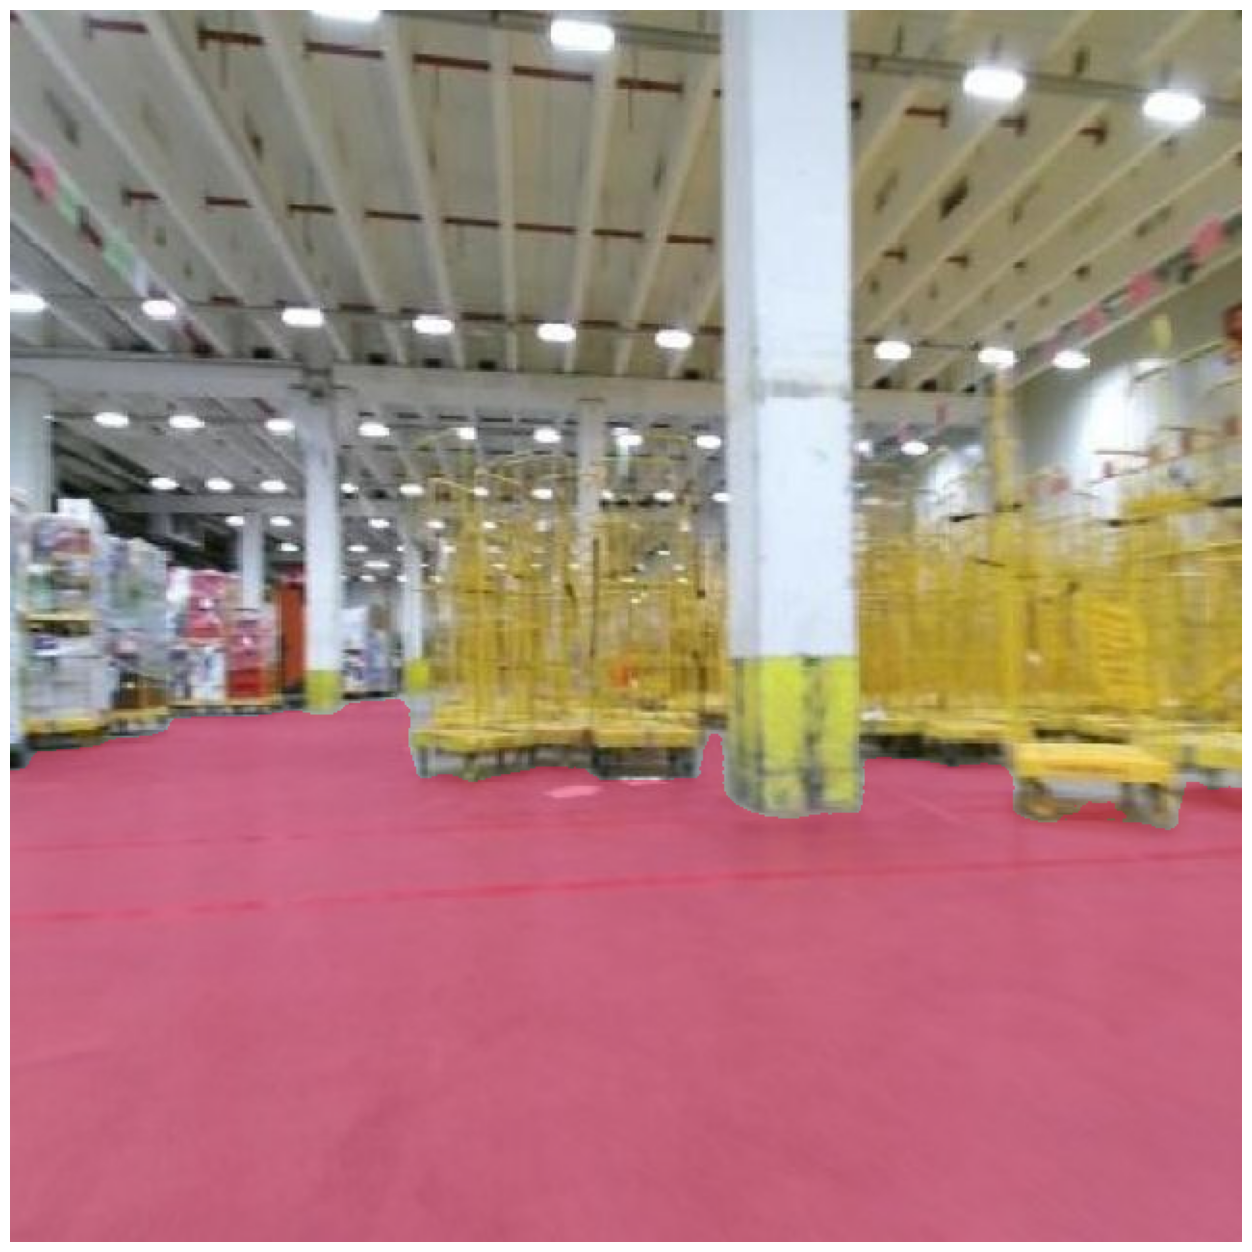

In [37]:
image_names = list(object_detection_dataset.images.keys())
image_name = random.choice(image_names)

image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]

mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))

### Save labels in Pascal VOC XML

Before uploading our annotations to Roboflow, we must first save them to our hard drive. To do this, we will use one of the latest `supervision` features (available with the `0.6.0` update 🔥) - [dataset save](https://roboflow.github.io/supervision/dataset/core/).

In [38]:
ANNOTATIONS_DIRECTORY = os.path.join(dataset.location, 'annotations')

MIN_IMAGE_AREA_PERCENTAGE = 0.002
MAX_IMAGE_AREA_PERCENTAGE = 0.80
APPROXIMATION_PERCENTAGE = 0.75

In [ ]:
object_detection_dataset.as_pascal_voc(
    annotations_directory_path=ANNOTATIONS_DIRECTORY,
    min_image_area_percentage=MIN_IMAGE_AREA_PERCENTAGE,
    max_image_area_percentage=MAX_IMAGE_AREA_PERCENTAGE,
    approximation_percentage=APPROXIMATION_PERCENTAGE
)

### Upload annotations to Roboflow

Now we are ready to upload our annotations to Roboflow using the API.

In [ ]:
import roboflow
from roboflow import Roboflow

roboflow.login()

workspace = Roboflow().workspace()
new_project = workspace.create_project(
    project_name=dataset.name,
    project_license="MIT",
    project_type="instance-segmentation", 
    annotation=f"{dataset.name}-boxes-to-segmentations")

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os

image_paths = sv.list_files_with_extensions(directory=f"{dataset.location}/train", extensions=["jpg", "jpeg", "png"])
for image_path in tqdm(image_paths):
    image_name = image_path.name
    annotation_name = f"{image_path.stem}.xml"
    image_path = str(image_path)
    annotation_path = os.path.join(ANNOTATIONS_DIRECTORY, annotation_name)
    new_project.upload(
        image_path=image_path, 
        annotation_path=annotation_path, 
        split="train", 
        is_prediction=True, 
        overwrite=True, 
        tag_names=["auto-annotated-with-grounded-sam"],
        batch_name="auto-annotated-with-grounded-sam"
    )

## Next steps

- If you liked the tutorial please leave ⭐ in our [supervision](https://github.com/roboflow/supervision) and [notebooks](https://github.com/roboflow/notebooks) repos.
- Review your dataset in Roboflow, correct any errors Grounding DINO / SAM made and [train real-time model](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/).
- [SAM is built into Roboflow annotation tool as well](https://youtu.be/NAL2xcmMJiQ). If you need to refine the masks you can do it interactively in the browser.

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.